## 3. 应用卷积神经网络实现情感分类

### 思路：

* 数据清理：
    + 删除停止词
    + 统计 counter
    + 导出 train 和 test 各自的 data 以及 target
* 构造模型：
    + 设定模型神经网络框架
    + 设定参数
    + 设定卷积层和池化层
    + 输出
* 展示：
    + 脚本化：数据清理和模型训练分为不一样的脚本
    + 矩阵图

### 笔记和思考：

* 卷积层的作用是什么？
* 卷积层有什么特性？
* 为什么卷积核的深度和当前层一样？为什么卷积不会改变深度？
* 池化层的作用和特性分别是什么？
* Max pooling 和 average pooling 的区别是什么？
* 构造卷积神经网络有哪些通用框架？处理图像数据和文本分类数据有什么注意的地方？

### 环境说明：

In [1]:
%load_ext watermark
%watermark -a 'Scott Ming' -v -m -d -p numpy,pandas,matplotlib,tensorflow

Scott Ming 2017-04-14 

CPython 3.6.0
IPython 5.3.0

numpy 1.12.1
pandas 0.19.2
matplotlib 2.0.0
tensorflow 1.0.1

compiler   : GCC 4.9.2
system     : Linux
release    : 3.16.0-4-amd64
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit


### 1. 清理数据

In [2]:
!ls

ch5_task1.ipynb   data			   saved_model
ch5_task2.ipynb   lena512.png		   script_introduction.ipynb
ch5_task4.ipynb   nn_language_model.ipynb  test_shuffle.txt
cnn.py		  practice		   text_cnn.py
conv_image.ipynb  __pycache__		   text_helpers.py
conv_nlp.ipynb	  README.md		   train_shuffle.txt


In [3]:
!head -n 5 train_shuffle.txt  

装了xp系统后，没有出现网友说的驱动不好装的情况	1
总的来说,比较干净,而且地理位置很好,市区繁华地段.进出方便.	1
2、散热很好，这个不用解释了	1
温度控制的非常好，噪音也不大，	1
早上6点多有"按摩"电话过来，^_^；不想被打扰的话拔掉电话插头吧	1


检查下数据的列总数

In [4]:
!awk -F'\t' '{print "Column counts: " NF; exit}' train_shuffle.txt

Column counts: 2


In [5]:
!awk -F'\t' '{print "Column counts: " NF; exit}' test_shuffle.txt

Column counts: 2


In [6]:
!ls

ch5_task1.ipynb   data			   saved_model
ch5_task2.ipynb   lena512.png		   script_introduction.ipynb
ch5_task4.ipynb   nn_language_model.ipynb  test_shuffle.txt
cnn.py		  practice		   text_cnn.py
conv_image.ipynb  __pycache__		   text_helpers.py
conv_nlp.ipynb	  README.md		   train_shuffle.txt


数据清理由 text_helper.py 执行

In [7]:
%matplotlib inline

import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from text_helpers import build_dataset

In [8]:
# %%time
# build_dataset('train_shuffle.txt', 'test_shuffle.txt', 
#               'data/stop_words_chinese.txt', n=10, max_words=20)
# 2 mins

In [9]:
!ls ../data

cleared_data.pkl  loss.png	     stop_words_chinese.txt  train_data.txt
embed.png	  reversed_dict.pkl  test_data.txt	     word_dict.pkl


### 2. 创建数据集

In [10]:
train = np.loadtxt('data/train_data.txt', dtype=int)
test = np.loadtxt('data/test_data.txt', dtype=int)

In [11]:
x_train = train[:, :-1]
y_train = train[:, -1:].reshape((-1,))
x_test = test[:, :-1]
y_test = test[:, -1:].reshape((-1,))

### 3. 构建模型

In [12]:
reversed_dict = pickle.load(open('data/reversed_dict.pkl', 'rb'))

In [13]:
vocab_size = 80000
sentence_length = x_train.shape[1]
word_embed_size = 128
data_size = train.shape[0]
batch_size = 50
num_filters = 3

In [14]:
x = tf.placeholder(tf.int32, shape=[None, sentence_length], name='x-input')
y_ = tf.placeholder(tf.int32, shape=[None,], name='y-input')

In [15]:
word_embedding = tf.Variable(
    tf.random_uniform([vocab_size, word_embed_size])
)

In [16]:
embeds = tf.nn.embedding_lookup(word_embedding, x)
embeds_expand = tf.expand_dims(embeds, -1)

In [17]:
def inference(input_tensor):
    with tf.name_scope("conv-maxpool"):
        filter_num = 64
        window_size = 3
        filter_shape = [window_size, word_embed_size, 1, filter_num]
        # W 和 b 是卷积的参数
        W = tf.Variable(tf.random_uniform(filter_shape, -1.0, 1.0), name="W")
        # bias 和 filter_num 个数是一样的
        b = tf.Variable(tf.constant(0.0, shape=[filter_num]), name="b")
        # 步长为1，这里不做 Padding，因此句子太短的话可能要丢掉。可自行尝试加 padding（不加也不影响作业评分）
        conv = tf.nn.conv2d(
                        input_tensor,
                        W,
                        strides=[1, 1, 1, 1],
                        padding="VALID",
                        name="conv")
        # 卷积出来的结果加上 bias
        conv_hidden = tf.nn.tanh(tf.add(conv, b), name="tanh")
    
        # 因为没有 padding，出来的结果个数是 sequence_length - window_size + 1，如果加了 padding 这里要对应更改。
        pool = tf.nn.max_pool(
                        conv_hidden,
                        ksize=[1, sentence_length - window_size + 1, 1, 1],
                        strides=[1, 1, 1, 1],
                        padding='VALID',
                        name="pool")
    
        pool_shape = pool.get_shape().as_list()
        # pool_shape[0] 为一个 batch 中数据的个数，即评论条数
        nodes = pool_shape[1] * pool_shape[2] * pool_shape[3]
        # 通过 tf.reshape 函数把 pool 层的输出编程一个 batch 的向量
        reshaped = tf.reshape(pool, [-1, nodes])  # -1 表示尽可能的展平
        logits = tf.layers.dense(reshaped, 2)
        return logits

In [18]:
logits = inference(embeds_expand)
cost = tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=logits, labels=y_)  
y = tf.nn.softmax(logits)

In [19]:
# 计算预测值
prediction = tf.arg_max(y, 1)
# 判断两个张亮的每一维度是否相等
correct_prediction = tf.equal(
    tf.cast(prediction, tf.int32), y_)
# 先将布尔型的数值转为实数型，然后计算平均值
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 设定两者的 feed_dict 方便计算 accuracy
train_feed_dict = {
    x: x_train, 
    y_: y_train,
}
test_feed_dict = {
    x: x_test, 
    y_: y_test,
}

In [20]:
train_step = tf.train.AdamOptimizer(0.001).minimize(cost)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    STEP = 5000
    for i in range(STEP):
        batch_data = train[np.random.randint(train.shape[0], size=batch_size), :]
        X = batch_data[:, :-1]
        Y = batch_data[:, -1:].reshape((-1,))
        feed_dict={x: X, y_: Y}
        sess.run(train_step, feed_dict=feed_dict)
        if i % 500 == 0:
            total_cross_entropy = cost.eval(feed_dict=feed_dict)[0]
            train_accuracy = accuracy.eval(feed_dict=train_feed_dict)
            test_accuracy = accuracy.eval(feed_dict=test_feed_dict)
            test_prediction = prediction.eval(feed_dict=test_feed_dict)
            print("After %d training step(s), cross entropy on batch data is "
                  "%f, trian accuracy is %.2f, test accuracy is %.2f" % (
                      i, total_cross_entropy, train_accuracy, test_accuracy))

After 0 training step(s), cross entropy on batch data is 1.515462, trian accuracy is 0.54, test accuracy is 0.53
After 500 training step(s), cross entropy on batch data is 0.646886, trian accuracy is 0.84, test accuracy is 0.78
After 1000 training step(s), cross entropy on batch data is 0.101600, trian accuracy is 0.93, test accuracy is 0.84
After 1500 training step(s), cross entropy on batch data is 0.034075, trian accuracy is 0.96, test accuracy is 0.87
After 2000 training step(s), cross entropy on batch data is 0.005170, trian accuracy is 0.98, test accuracy is 0.89
After 2500 training step(s), cross entropy on batch data is 0.040701, trian accuracy is 0.99, test accuracy is 0.90
After 3000 training step(s), cross entropy on batch data is 0.002401, trian accuracy is 0.99, test accuracy is 0.91
After 3500 training step(s), cross entropy on batch data is 0.000302, trian accuracy is 0.99, test accuracy is 0.91
After 4000 training step(s), cross entropy on batch data is 0.000007, trian 

这里调用 [Plot confusion matrix - mlxtend](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/)，函数详情可以参考 [Reading-a-confusion-matrix](http://nbviewer.jupyter.org/github/rasbt/python-machine-learning-book/blob/master/code/ch06/ch06.ipynb#Reading-a-confusion-matrix)。


In [21]:
binary = confusion_matrix(y_true=y_test, y_pred=test_prediction)

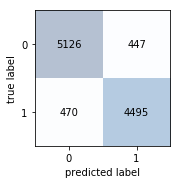

In [22]:
plot_confusion_matrix(binary)
plt.show()

## Refrences:

* [CNN在情感分析上的应用之论文列表 | Sentiment Mining](http://sentiment-mining.blogspot.com/2015/10/cnn.html)
* [卷积神经网络(CNN)在句子建模上的应用 | Jey Zhang](http://www.jeyzhang.com/cnn-apply-on-modelling-sentence.html)
* [卷积神经网络（CNN）概述及其在NLP中的应用（一） - liuyuemaicha的专栏 - 博客频道 - CSDN.NET](http://blog.csdn.net/liuyuemaicha/article/details/53728242)
* [利用TensorFlow实现卷积神经网络做文本分类 - 简书](http://www.jianshu.com/p/ed3eac3dcb39)
* [CNN笔记：通俗理解卷积神经网络 - 结构之法 算法之道 - 博客频道 - CSDN.NET](http://blog.csdn.net/v_july_v/article/details/51812459).
* [用深度学习（CNN RNN Attention）解决大规模文本分类问题 - 综述和实践 - 知乎专栏](https://zhuanlan.zhihu.com/p/25928551)


#### 脚本化：

* [coding style - What is the standard Python docstring format? - Stack Overflow](http://stackoverflow.com/questions/3898572/what-is-the-standard-python-docstring-format)
* [Example Google Style Python Docstrings — napoleon 0.6.0 documentation](http://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_google.html)
* [PEP 257 -- Docstring Conventions | Python.org](https://www.python.org/dev/peps/pep-0257/)
* [numpy/numeric.py at master · numpy/numpy](https://github.com/numpy/numpy/blob/master/numpy/core/numeric.py)
* [How to write effective Docstrings (Example) | hack.guides()](https://www.pluralsight.com/guides/python/how-to-write-effective-docstrings?status=in-review)


#### Stackoverflow

* [python - Rank mismatch: Rank of labels (received 2) should equal rank of logits minus 1 (received 2) - Stack Overflow](http://stackoverflow.com/questions/40350849/rank-mismatch-rank-of-labels-received-2-should-equal-rank-of-logits-minus-1)